<b><font size=20, color='#A020F0'>Final Project</font></b>

The overall goal of this project was to look at snowfall rates across the polar regions. I will look at extreme regions as well as overall trends.

Below are all the imports to needed for my project.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.colors as mplc
import matplotlib.cm as cm
import cartopy.util as util

## Reading in and exploring the data

First, I will be working with gridded monthly snowfall data. These files were created by Marian Mateling, using the C3S satellite product. Each file contains one month worth of data, but I want to analyse a few years worth of data. In the following cell, I read in the data using xarray. Unfortunatley, when I tried to use the function 'open_mfdataset', xarray was unable to read in the data because of some missing information. In order to properly read in the data the way I wanted, I added a time dimention and assigned lat and lon as coordinates before concatenating the data.

In [2]:
filelist = glob('monthly_c3s/fixed_snowfall_*') #get a list of all the files
for file in filelist:
    ds = xr.open_dataset(file) #open the file using xarray
    ds = ds.assign_coords(lon=ds.Longitude, lat=ds.Latitude) #assign coordinates
    year = int(file[27:31])
    month = int(file[31:33])
    times = [datetime(year, month, 1)]
    time_da = xr.DataArray(times, [('time', times)]) #make DA with the date
    ds = ds.expand_dims(time=time_da) #add the time dim to the dataset
    
    if file[27:33] == '200701': #for the first file, establish a new dataset for the other files to concat with
        ds_total = ds
        
    else:
        ds_total = xr.concat([ds_total, ds], dim='time') #concat this dataset with the total dataset

ds_total now contains all the monthly files from 2007 to 2010.


<font color=red>Note: 2009 is missing data from September to December due to an issue with the Satellite.
    
    
There are a lot of variables in the dataset, but for this project I will just be using joint_total_snow and joint_total_counts. joint_total_snow is the sum of all snowfall rates detected by the satellite within the gridbox. joint_total_counts is the number of datapoints in each gridbox. If we divide total snow by total counts, we will get the average snow rate (mm/hr). The files already have an averaged snowfall rate called joint_mean_snow, but that variable won't work for the analysis I want to do.
    
The following cells will find the average snowfall rate for each month and also the average snow rate for each gridcell for all time.

In [3]:
#extract the variables we want and mask the invalid values
total_snow = xr.where(ds_total['joint_total_snow'] == -999, np.nan, ds_total['joint_total_snow'])
total_counts = xr.where(ds_total['joint_total_counts'] == -999, np.nan, ds_total['joint_total_counts'])

In [4]:
#find the average snowfall rate for each month for the whole globe
global_snow = total_snow.sum('lon').sum('lat') #sum all snow for the globe
global_counts = total_counts.sum('lon').sum('lat') #sum all counts for the globe
global_rates = global_snow / global_counts #get a global snowfall rate for each month

In [5]:
stdz_snow = (global_rates - global_rates.mean()) / global_rates.std() #standardize the snow rates

In [6]:
#calculate the time averaged snow rates aka 1 snowrate per gridcell for all time
time_snow = total_snow.sum('time')
time_counts = total_counts.sum('time')
time_rates = time_snow / time_counts

In [7]:
#take only the lat above or below 60 N or S for plotting purposes
southern_hemi = time_rates.sel(lat=slice(-90,-62))
northern_hemi = time_rates.sel(lat=slice(60,90))

## Plotting

Now I want to plot the averages I just found. In the top cell, I made a line plot of snowfall rate anomalies over time. The bottom two plots are the average snowfall rates for all time for the Arctic and Antarctic. 

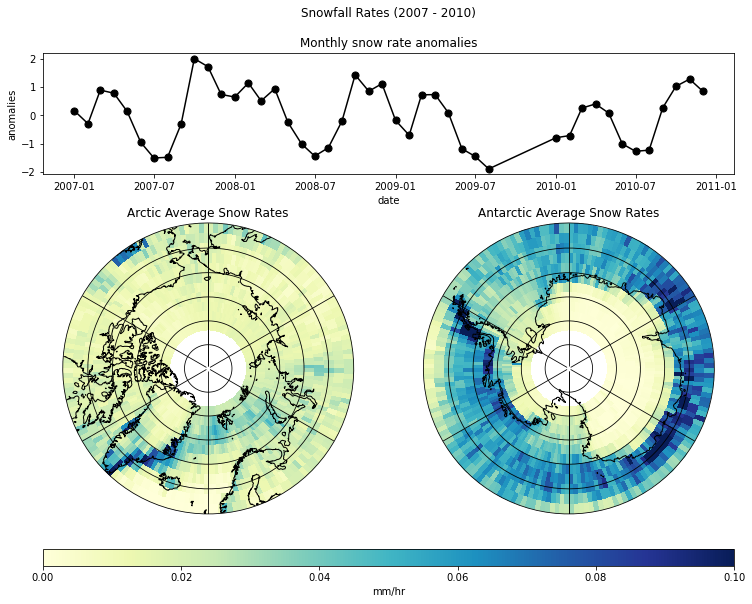

In [8]:
#set gridspec to 3 x 4
gs=gridspec.GridSpec(nrows=3,ncols=4)

#make cirular plot
theta = np.linspace(0,2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig=plt.figure(figsize = (12, 8))
ax1=fig.add_subplot(gs[0,:]) #upper left, single cell plot
ax1.set_xlabel('date')
ax1.set_ylabel('anomalies')
ax1.set_title('Monthly snow rate anomalies')
ax2=fig.add_subplot(gs[1:,:2], projection=ccrs.NorthPolarStereo()) #top row, spans three cells
ax2.set_boundary(circle, transform = ax2.transAxes)
ax2.coastlines(color='black')
ax2.set_title('Arctic Average Snow Rates')
ax3=fig.add_subplot(gs[1:,2:], projection=ccrs.SouthPolarStereo()) #two middle rows, first two cells each 
ax3.set_boundary(circle, transform = ax3.transAxes)
ax3.coastlines(color='black')
ax3.set_title('Antarctic Average Snow Rates')

ax1.plot(stdz_snow.time, stdz_snow, color = 'black')
ax1.scatter(stdz_snow.time, stdz_snow, color = 'black', s = 50)
cs = ax2.pcolormesh(np.arange(-180, 182, 2),np.arange(60, 92, 2),northern_hemi.T.values,cmap=plt.cm.YlGnBu,transform=ccrs.PlateCarree(), vmin = 0, vmax = .1)
cs1 = ax3.pcolormesh(np.arange(-180, 182, 2),np.arange(-90, -58, 2),southern_hemi.T.values,cmap=plt.cm.YlGnBu,transform=ccrs.PlateCarree(), vmin = 0, vmax = .1)

ax2.gridlines(color = 'black')
ax3.gridlines(color = 'black')
cax=fig.add_axes([0.1,0.01,0.8,0.03])
cbar=plt.colorbar(cs,cax=cax,orientation='horizontal', label = 'mm/hr')
fig.suptitle('Snowfall Rates (2007 - 2010)')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
plt.show()

From this plot, we can see some basic seasonal trends in snowfall. The biggest negative anomalies are found in the months of June, July, and August. The biggest positive anomalies are found in October, November, and December. We can also see that the largest snowfall rates occur on the coasts of Greenland and Anarctica. There is also significantly more snowfall in the Southern Hemisphere Ocean than in the Northern Hemisphere. We can also see there is no data in the center of the plots (white circle). This is because the Satellites do not orbit between 82-90 degrees North and South

## Extreme Months in the dataset

Next, I'm going to look at the month with the highest and lowest snowfall rates. By running the following cell, I determined that the highest average snowfall rate occured in October 2007, and the lowest snowfall rate was in August 2009. Let's look at how different these months are compared to the dataset as a whole. Next, I will select those months in order to find the average snowfall rates. I then subtracted the overall average rates to find the difference from extreme month to average month.

In [9]:
# stdz_snow.where(stdz_snow==stdz_snow.max(), drop=True)
# stdz_snow.where(stdz_snow==stdz_snow.min(), drop=True)

In [10]:
#select max month and find averages
max_snow = total_snow.sel(time='2007-10').sum('time')
max_counts = total_counts.sel(time='2007-10').sum('time')
max_rates = max_snow / max_counts

In [11]:
#select min month and find averages
min_snow = total_snow.sel(time='2009-08').sum('time')
min_counts = total_counts.sel(time='2009-08').sum('time')
min_rates = min_snow / min_counts

In [12]:
#find difference from the mean
max_anom = max_rates - time_rates
min_anom = min_rates - time_rates

In [13]:
#find NH and SH for plotting
sh_max = max_anom.sel(lat=slice(-90,-62))
nh_max = max_anom.sel(lat=slice(60,90))
sh_min = min_anom.sel(lat=slice(-90,-62))
nh_min = min_anom.sel(lat=slice(60,90))

In [14]:
#make a list for plotting purposes 
anoms = [sh_max, nh_max, sh_min, nh_min]

## Plot Extremes

Next I will plot the NH and SH differences for the min and max extreme months

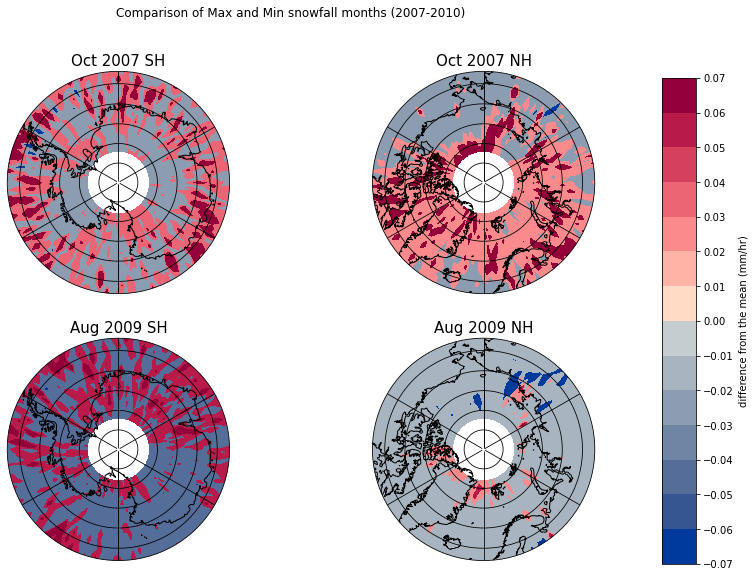

In [15]:
gs = gridspec.GridSpec(nrows=2,ncols=2)
fig = plt.figure(figsize =(12,9))
fig.suptitle("Comparison of Max and Min snowfall months (2007-2010)")
title_list = ['Oct 2007 SH', 'Oct 2007 NH', 'Aug 2009 SH', 'Aug 2009 NH']
cmap = mplc.ListedColormap(['#003a9c', '#365692', '#546e99', '#6f85a4', '#8c9db1', '#a8b5c0', '#c6cdd0', '#ffdac4', '#ffb3a7', '#fb8a8c', '#eb6574', '#d5405e', '#b81b4a', '#93003a'])

#make circular axis
theta = np.linspace(0,2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
lons = np.arange(0, 360, 2)

for i in range(len(anoms)):
    
    n = i//2
    m = i % 2
    
    cyclic_data, cyclic_lons = util.add_cyclic_point(anoms[i].T, coord=lons)
    
    if i == 0 or i == 2:
        ax = fig.add_subplot(gs[n,m], projection = ccrs.SouthPolarStereo())
        ax.set_boundary(circle, transform = ax.transAxes)
        ax.contourf(cyclic_lons,np.arange(-90, -60, 2), cyclic_data, transform = ccrs.PlateCarree(), cmap = cmap, vmin = -.07, vmax = .07)
        
    elif i == 1 or i == 3:
        ax = fig.add_subplot(gs[n,m], projection = ccrs.NorthPolarStereo())
        ax.set_boundary(circle, transform = ax.transAxes)
        ax.contourf(cyclic_lons,np.arange(62, 92, 2), cyclic_data, transform = ccrs.PlateCarree(), cmap = cmap, vmin = -.07, vmax = .07)
        #print(cyclic_data)
        
    ax.coastlines()
    ax.gridlines(color = 'black')
    ax.set_title(title_list[i], fontsize = 15)
    
cax = fig.add_axes([0.93, 0.12, 0.04, 0.75])
norm = mplc.Normalize(vmin = -.07, vmax = .07)
cs = cm.ScalarMappable(norm = norm, cmap = cmap)
cbar = plt.colorbar(cs, cax = cax, orientation = "vertical", cmap = cmap, label = "difference from the mean (mm/hr)", ticks = np.arange(-.07, .07, .01))

From the plots, it does not look like there is a clear pattern of regions with higher or lower snowfall rates. Interestingly, in August 2009, most regions in the arctic seem to have about average snowfall rates. Whereas the antarctic has both extreme lows and highs. 

## Bringing in AWS data

Next, I will look at some of the surface conditions in Antarctica using AWS data from the amrdc (Antarctic Meteorologicaal Research and Data Center). Due to a lack of data, I couldn't look at the most extreme month, so I chose November 2010, which was one of the higher months for snowfall. First I calculated the monthly snowfall rate for Nov 2010 in the same way I did previously.

In [16]:
month_snow = total_snow.sel(time='2010-11').sum('time')
month_counts = total_counts.sel(time='2010-11').sum('time')
month_rates = month_snow / month_counts

Then, I read in a file called 'aws_stations'. This is a csv of all the stations for 2010 I found using this [link.](http://amrc.ssec.wisc.edu/aws/station_list.php) On my personal jupyter notebook, I was able to read in the data directly from the website using pd.read_url() and then turn it into a csv. I could not use that command in this notebook because it is not in the environment. I also used that notebook to seperate the lat and lon columns. I then used the lat and lon of each station to find the gridpoint that the aws falls into from the nov 2010 variable and added the snowfall rate to the dataframe. I needed to use the 'ffill' method because the lat/lon in the C3S files are the lower left corner of the gridpoint. ex: if the gridpoint has a lat = -80 and lon = 120, the gridbox covers lat -80 to -78 and lon 120 to 122.

In [17]:
aws = pd.read_csv('aws_stations.csv')

In [18]:
rate = []
for i in range(len(aws)):
    rate.append(month_rates.sel(lat=aws.Lat[i], lon=aws.Lon[i], method = 'ffill').values)
aws['snow_rate'] = rate 

I then plotted the all the stations with a colorbar corresponding to their snowfall rate. 

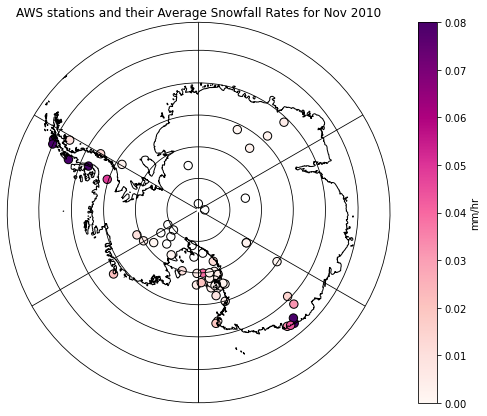

In [19]:


theta = np.linspace(0,2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=180))
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree()) #only plot from -90 to -60
ax.coastlines(resolution='10m') 
ax.invert_yaxis() #I needed to invert the x and y axis in order to make the orientation of antarctica I wanted
ax.invert_xaxis()
ax.set_boundary(circle, transform = ax.transAxes)
ax.gridlines(color = 'black')
transform = ccrs.PlateCarree()._as_mpl_transform(ax)

cs = plt.scatter(aws.Lon, aws.Lat, s = 70, transform = transform, c = aws.snow_rate, cmap = plt.cm.RdPu, edgecolors = 'black', vmin = 0, vmax = .08)
cbar=plt.colorbar(cs,label = 'mm/hr')

plt.title('AWS stations and their Average Snowfall Rates for Nov 2010')
plt.show()

From this plot, we can see that some of the highest snowfall rates are near the coasts. Specifically on the Antarctic Peninsula and the Adelie Coast. The more inland stations have much lower snowfall rates. The default Cartopy coastlines do not includee the permantent iceshelves, like the ross ice shelf. This makes some of the stations look like they are floating in the ocean, which is not true. 

## Extreme Stations

Next I will look at a full months worth of data from 2 stations. The first is Dismal Island which had the highest snowrate for this month (0.397 mm/hr). The second station I looked at was Siple Dome. This station did not have the very lowest snowfall rate but it was one of the lowest ones (.0011 mm/hr). There were 3 stations with lower snowfall rates, but they did not have complete data for the month I was looking at. Siple Dome still has some missing data at the beginning of the month but it still has enough data to look at an overall trend. 

Below I made a quick plot of where the 2 stations are using similar code to the previous plot.

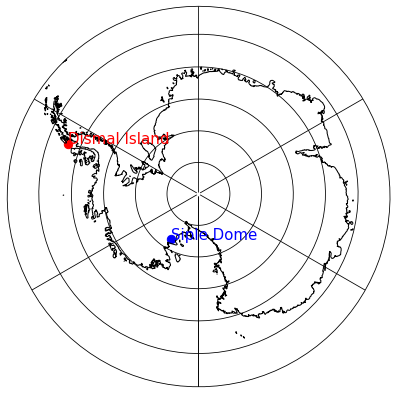

In [20]:
theta = np.linspace(0,2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=180))
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_boundary(circle, transform = ax.transAxes)
ax.gridlines(color = 'black')
transform = ccrs.PlateCarree()._as_mpl_transform(ax)

dismal = aws[aws['Station Name'] == 'Dismal Island']
plt.scatter(dismal.Lon, dismal.Lat, s = 70, transform = transform, c = 'red')
plt.text(s = 'Dismal Island', x = dismal.Lon, y = dismal.Lat, transform = transform, fontsize = 15, c= 'red')

siple = aws[aws['Station Name'] == 'Siple Dome']
plt.scatter(siple.Lon, siple.Lat, s = 70, transform = transform, c = 'blue')
plt.text(s = 'Siple Dome', x = siple.Lon, y = siple.Lat, transform = transform, fontsize = 15, c= 'blue')

plt.show()

I found this data on the [AMRDC data repository](https://amrdcdata.ssec.wisc.edu/) The data I used was the quality controlled 3-hourly data. I could then use read_csv to read in the data directly from the txt file url. 

In [21]:
url= 'https://amrdcdata.ssec.wisc.edu/dataset/97b3ddb6-5832-4d9d-b5d2-f3681c520dde/resource/cc996b95-3a69-4871-8b6a-a039c9befb82/download/3hr-dis201011q3h.txt'
df=pd.read_csv(url, skiprows = 2, header = None, delimiter = '\s+', engine = 'python', names = ['Year', 'Julian day', 'Month', 'Day', 'Observation time (UTC)', 
'Temperature (C)', 'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (deg)', 'Relative Humidity (%)', 'Delta-T (C)'])

In [22]:
url='https://amrdcdata.ssec.wisc.edu/dataset/8af5ec2e-4de3-47cd-b994-9d3bccba83b6/resource/33c72f6c-ab80-45e3-b830-f3797a8793fc/download/3hr-sid201011q3h.txt'
df2=pd.read_csv(url, skiprows = 2, header = None, delimiter = '\s+', engine = 'python', names = ['Year', 'Julian day', 'Month', 'Day', 'Observation time (UTC)', 
'Temperature (C)', 'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (deg)', 'Relative Humidity (%)', 'Delta-T (C)'])

I made a list of the dates using datetime to combine the year, month, day, and time variables from the dataframe. Since I am just using this for plotting purposes and both dataframes span the same month, I just made this list using the Dismal Island dataframe.

In [23]:
times = []
for i in range(len(df)):
    times.append(datetime(df.Year[i], df.Month[i], df.Day[i], int(df['Observation time (UTC)'][i]/100)))

Next, I am plotting temperature and relative humidity vs time for both the stations. The bottom 2 plots are histograms of the wind speed and direction. The first 3 plots use basic ax.plot or ax.hist, but the fourth plot is a circular histogram which takes a little more explaination so the steps are commented below.

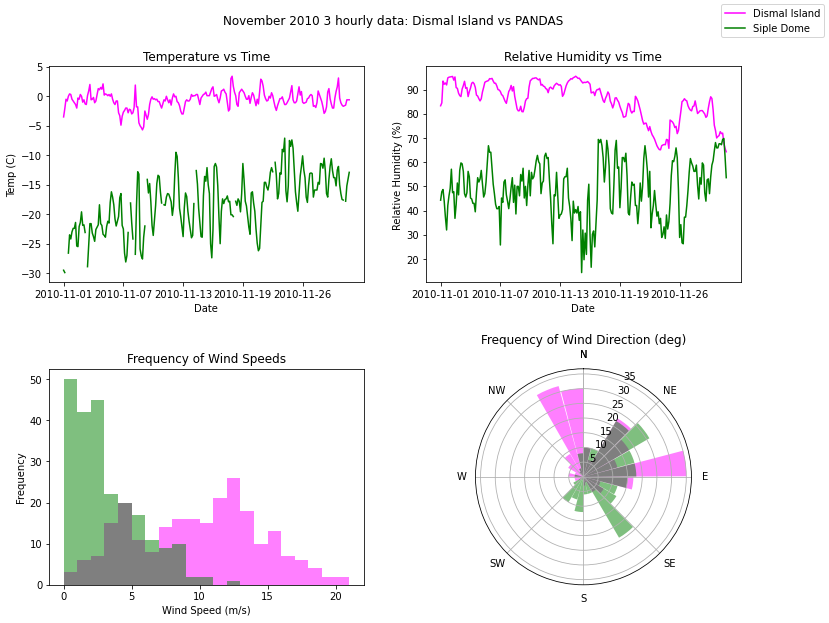

In [24]:
gs = gridspec.GridSpec(nrows=2,ncols=2)
fig = plt.figure(figsize =(12,9))

temp = np.ma.masked_where(df['Temperature (C)'] == 444, df['Temperature (C)']) #444 is the invalid data, I needed to mask these out for every variable
rh = np.ma.masked_where(df['Relative Humidity (%)'] == 444, df['Relative Humidity (%)'])
deg = df[df['Wind Direction (deg)'] != 444]['Wind Direction (deg)']
wind = np.ma.masked_where(df['Wind Speed (m/s)'] == 444, df['Wind Speed (m/s)'])

temp2 = np.ma.masked_where(df2['Temperature (C)'] == 444, df2['Temperature (C)'])
rh2 = np.ma.masked_where(df2['Relative Humidity (%)'] == 444, df2['Relative Humidity (%)'])
deg2 = df2[df2['Wind Direction (deg)'] != 444]['Wind Direction (deg)']
wind2 = np.ma.masked_where(df2['Wind Speed (m/s)'] == 444, df2['Wind Speed (m/s)'])

c1 = 'fuchsia' #this color is for Dismal Island
c2 = 'green' #this color is for Siple Dome

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(times, temp, c = c1)
ax1.plot(times, temp2, c = c2)
ax1.set_xticks(times[::50])
ax1.set_xlabel('Date')
ax1.set_ylabel('Temp (C)')
ax1.set_title('Temperature vs Time')

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(times, rh, c = c1, label = 'Dismal Island')
ax2.plot(times, rh2, c = c2, label = 'Siple Dome')
ax2.set_xticks(times[::50])
ax2.set_xlabel('Date')
ax2.set_ylabel('Relative Humidity (%)')
ax2.set_title('Relative Humidity vs Time')

ax3 = fig.add_subplot(gs[1,0])
bins = np.linspace(0, 21, 22)
ax3.hist(wind, bins, alpha = .5, color = c1)
ax3.hist(wind2, bins, alpha = .5,color = c2)
ax3.set_xlabel('Wind Speed (m/s)')
ax3.set_ylabel('Frequency')
ax3.set_title('Frequency of Wind Speeds')

ax4 = fig.add_subplot(gs[1,1],  projection='polar') #projection set to polar to make a circular plot
width = (2*np.pi) / 25  #set width of each bar which is 2 pi / the number of bars I have
bins = np.linspace(0, 360, 25) #bins is the number of degrees divided into 24 incraments
theta = (bins[:-1] + 7.5)* np.pi / 180 #this will be the center point of each bar 
radii, a = np.histogram(deg, bins=bins) #np.histogram separates the data into bins for plotting
radii2, a = np.histogram(deg2, bins=bins) #histogram has 2 outputs, but we only need the first one. a is just a repeat of the bins we already created
ax4.bar(theta, radii, width=width, bottom=0.0, alpha = .5, color = c1) #use ax.bar to plot theta vs radii
ax4.bar(theta, radii2, width=width, bottom=0.0, alpha = .5, color = c2)
ax4.set_theta_zero_location("N") #this makes sure 0 degrees is at the top of the graph consistant with 0 degrees = Northerly wind
ax4.set_theta_direction(-1) #make theta go clockwise, default is counter-clockwise
ax4.set_xticks(np.linspace(0, 2*np.pi, 9), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']) #set the x/theta values to the cardinal directions
ax4.set_title('Frequency of Wind Direction (deg)')

plt.suptitle('November 2010 3 hourly data: Dismal Island vs PANDAS ')
plt.figlegend() #set a legend for the entire plot

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)

From these plots, we start to get an idea of why these 2 stations would get such different amounts of snow. Siple Dome has much lower temperatures, relative humidity, and wind speeds than Dismal Island. Dismal Island receives a lot of wind from the N and NW, this is bringing warm moist air from the surounding ocean. However, the station also has some Easterly wind which would bring colder, drier air from the mountains on the peninsula. Siple Dome has a bigger range of winds, but mostly NE to SE winds. This would bring cold dry air from the ross iceshelf. 

## Conclusion

This project has helped me explore snowfall data in the poles, specifically Antarctica. It was interesting get a look at seasonal snowfall patterns as well as spacial trends. In the future, I would like to explore more conditions at more AWS stations and look at specific snowfall events. 